In [2]:

import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    matthews_corrcoef, hamming_loss, multilabel_confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import cv2

# Parameters
image_dir = "/Users/anatatar/Desktop/Licenta/ai_models/data/ecg_images_final"
csv_path = "/Users/anatatar/Desktop/Licenta/ai_models/data/labeled_ecg_images.csv"
target_classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
image_size = (224, 224)
random_state = 42

os.makedirs("densenet", exist_ok=True)


In [3]:

df = pd.read_csv(csv_path)

def find_image_path(filename):
    for folder in os.listdir(image_dir):
        path = os.path.join(image_dir, folder, filename)
        if os.path.exists(path):
            return path
    return None

df['image_path'] = df['filename'].apply(find_image_path)
df = df[df['image_path'].notnull()]
print(f"✅ Total usable samples (multi-label): {len(df)}")

train_df, test_df = train_test_split(df, test_size=0.15, random_state=random_state)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=random_state)

def load_or_cache_images(df_subset, name):
    X_path = f"densenet/X_{name}.npy"
    y_path = f"densenet/y_{name}.npy"
    if os.path.exists(X_path) and os.path.exists(y_path):
        print(f"✅ Loading cached {name} data...")
        X = np.load(X_path)
        y = np.load(y_path)
    else:
        print(f"⏳ Caching {name} data...")
        X, y = [], []
        for _, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc=f"Loading {name} images"):
            img = load_img(row['image_path'], color_mode='rgb', target_size=image_size)
            img_array = img_to_array(img) / 255.0
            label_vector = row[target_classes].values.astype(np.float32)
            X.append(img_array)
            y.append(label_vector)
        X, y = np.array(X), np.array(y)
        np.save(X_path, X)
        np.save(y_path, y)
    return X, y

X_train, y_train = load_or_cache_images(train_df, "train")
X_val, y_val = load_or_cache_images(val_df, "val")
X_test, y_test = load_or_cache_images(test_df, "test")


✅ Total usable samples (multi-label): 21799
✅ Loading cached train data...
✅ Loading cached val data...
✅ Loading cached test data...


In [4]:

inputs = Input(shape=(224, 224, 3))
base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=inputs)
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output = Dense(len(target_classes), activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)

for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= len(base_model.layers) - 40

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[AUC(curve='ROC', multi_label=True, name='auc'),
             Precision(name='precision'),
             Recall(name='recall'),
             'accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=25,
                    batch_size=8,
                    callbacks=[early_stopping],
                    verbose=1)

model.save("densenet/densenet_model.h5")
with open("densenet/history.json", "w") as f:
    json.dump(history.history, f)


Epoch 1/25
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 640s 322ms/step - accuracy: 0.5087 - auc: 0.7259 - loss: 0.4911 - precision: 0.5743 - recall: 0.4197 - val_accuracy: 0.6191 - val_auc: 0.8747 - val_loss: 0.3530 - val_precision: 0.7247 - val_recall: 0.6130
Epoch 2/25
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 628s 319ms/step - accuracy: 0.6010 - auc: 0.8355 - loss: 0.3962 - precision: 0.7018 - recall: 0.5572 - val_accuracy: 0.6392 - val_auc: 0.8816 - val_loss: 0.3343 - val_precision: 0.7600 - val_recall: 0.6282
Epoch 3/25
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 669s 340ms/step - accuracy: 0.6208 - auc: 0.8548 - loss: 0.3740 - precision: 0.7265 - recall: 0.5858 - val_accuracy: 0.6396 - val_auc: 0.8870 - val_loss: 0.3332 - val_precision: 0.7634 - val_recall: 0.6279
Epoch 4/25
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 684s 347ms/step - accuracy: 0.6263 - auc: 0.8648 - loss: 0.3643 - precision: 0.7332 - recall: 0.5979 - val_accuracy: 0.6662 - val_auc: 0.8886 - val_loss: 0.3253 - val_precision: 0.7597 - val_recall: 0.6526
Epoch 5/

In [9]:
model.save("densenet/densenet_model.keras")


In [5]:
import numpy as np
from tensorflow.keras.models import load_model

# Load test data
X_test = np.load("densenet/X_test.npy")  # You must have saved this earlier
y_test = np.load("densenet/y_test.npy")

# Load model
model = load_model("/Users/anatatar/Desktop/Licenta/ai_models/src/densenet/densenet_model.h5")

# Evaluate

results = model.evaluate(X_test, y_test, verbose=1)
print("\nTest results:")
print(f"Loss: {results[0]:.4f} | AUC: {results[1]:.4f} | Precision: {results[2]:.4f} | Recall: {results[3]:.4f} | Accuracy: {results[4]:.4f}")

y_pred_probs = model.predict(X_test)
y_pred_bin = (y_pred_probs > 0.5).astype(int)

os.makedirs("densenet", exist_ok=True)
np.save("densenet/y_test.npy", y_test)
np.save("densenet/y_pred_bin.npy", y_pred_bin)
np.save("densenet/y_pred_probs.npy", y_pred_probs)

report = classification_report(y_test, y_pred_bin, target_names=target_classes, zero_division=0)
print(report)

with open("densenet/classification_report_densenet.txt", "w") as f:
    f.write(report)

with open("densenet/all_metrics_densenet.txt", "w") as f:
    f.write("Classification Report:\n" + report + "\n")
    binary_acc = (y_test == y_pred_bin).mean()
    f.write(f"Binary accuracy: {binary_acc:.4f}\n")

    try:
        f.write(f"AUROC macro: {roc_auc_score(y_test, y_pred_probs, average='macro'):.4f}\n")
        f.write(f"AUROC micro: {roc_auc_score(y_test, y_pred_probs, average='micro'):.4f}\n")
    except:
        pass
    try:
        f.write(f"AUPRC macro: {average_precision_score(y_test, y_pred_probs, average='macro'):.4f}\n")
        f.write(f"AUPRC micro: {average_precision_score(y_test, y_pred_probs, average='micro'):.4f}\n")
    except:
        pass

    f.write(f"Hamming Loss: {hamming_loss(y_test, y_pred_bin):.4f}\n")
    f.write(f"Subset Accuracy: {np.all(y_test == y_pred_bin, axis=1).mean():.4f}\n")
    f.write(f"MCC: {matthews_corrcoef(y_test.flatten(), y_pred_bin.flatten()):.4f}\n")

# Save confusion matrices
cm = multilabel_confusion_matrix(y_test, y_pred_bin)
for i, name in enumerate(target_classes):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Neg', 'Pred Pos'],
                yticklabels=['Actual Neg', 'Actual Pos'])
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.savefig(f"densenet/confusion_matrix_{name}.png")
    plt.close()


/Users/anatatar/Desktop/Licenta/ai_models/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


103/103 ━━━━━━━━━━━━━━━━━━━━ 96s 910ms/step - accuracy: 0.6808 - auc: 0.8911 - loss: 0.3258 - precision: 0.7813 - recall: 0.6364

Test results:
Loss: 0.3248 | AUC: 0.8916 | Precision: 0.7717 | Recall: 0.6406 | Accuracy: 0.6679


/Users/anatatar/Desktop/Licenta/ai_models/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


103/103 ━━━━━━━━━━━━━━━━━━━━ 99s 948ms/step
              precision    recall  f1-score   support

        NORM       0.80      0.86      0.83      1442
          MI       0.66      0.51      0.57       776
        STTC       0.76      0.60      0.67       792
          CD       0.84      0.52      0.64       778
         HYP       0.75      0.39      0.51       380

   micro avg       0.77      0.64      0.70      4168
   macro avg       0.76      0.58      0.65      4168
weighted avg       0.77      0.64      0.69      4168
 samples avg       0.69      0.66      0.66      4168



In [4]:
# Index of the class you care about (e.g., HYP)
hyp_index = target_classes.index("HYP")

# Index of the sample
sample_index = 0  # or any other index

# Check correctness
is_correct = y_test[sample_index, hyp_index] == y_pred_bin[sample_index, hyp_index]

print(f"Sample {sample_index} prediction for HYP: {'✅ Correct' if is_correct else '❌ Incorrect'}")


Sample 0 prediction for HYP: ✅ Correct


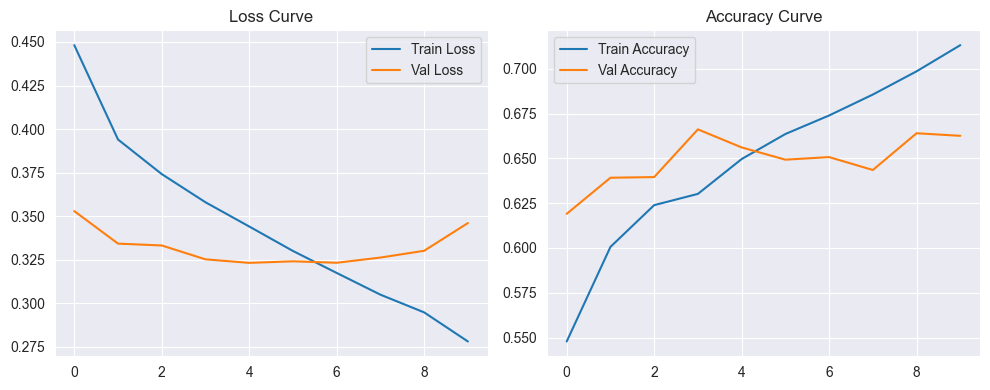

In [15]:

import matplotlib.pyplot as plt

import json

with open("/Users/anatatar/Desktop/Licenta/ai_models/src/densenet/history.json", "r") as f:
    history = json.load(f)


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history["accuracy"], label="Train Accuracy")
plt.plot(history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.savefig("densenet/loss_accuracy_curve.png")
plt.show()


In [7]:
def generate_grad_cam(model, image_array, class_index, output_path, last_conv_layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        inputs = tf.cast(np.expand_dims(image_array, axis=0), tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)[0]  # Shape: [H, W, C]
    conv_outputs = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))  # Now valid
    cam = np.zeros(conv_outputs.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, image_size)
    cam -= cam.min()
    cam /= cam.max()
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    img = np.uint8(255 * image_array)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    cv2.imwrite(output_path, overlay)
    print(f"✅ Grad-CAM saved to {output_path}")


In [8]:
for i, class_name in enumerate(target_classes):
    generate_grad_cam(
        model,
        X_test[0],
        class_index=i,
        output_path=f"densenet/gradcam_{class_name}_sample0.png",
        last_conv_layer_name="conv5_block16_concat"
    )


/Users/anatatar/Desktop/Licenta/ai_models/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


✅ Grad-CAM saved to densenet/gradcam_NORM_sample0.png
✅ Grad-CAM saved to densenet/gradcam_MI_sample0.png
✅ Grad-CAM saved to densenet/gradcam_STTC_sample0.png
✅ Grad-CAM saved to densenet/gradcam_CD_sample0.png
✅ Grad-CAM saved to densenet/gradcam_HYP_sample0.png
